In [1]:
# #### Notebook to view maps of MSE and related variables from TC output
# 
# Assumes key integrated variables have been processed and written out by PE_write.py to single-level netcdf files.
# 
# James Ruppert  
# jruppert@ou.edu  
# 4/9/23

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import colors
import subprocess
import cartopy
import sys
from mask_tc_track import mask_tc_track
import pandas as pd

In [3]:
# #### Main settings

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
# nmem = 10 # number of ensemble members
nmem = 1
imemb = 1 # Which member to plot?

# Time step to plot (CTL)
it_plt0=38

ptop = 100 # top for integrals; hPa
prplot = 600 # hPa level for winds

formula='vadv'#'hflux'#'converg'#

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/mse/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Ens member strings
imemb-=1 # index of member to read
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

In [4]:
# Get Lat/Lon
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
process = subprocess.Popen(['ls '+datdir+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()
lon1d=lon[0,:]
lat1d=lat[:,0]

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/post/d02/'
fil = Dataset(datdir+'U.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
fil.close()
nk=np.size(pres)
iktop = np.where(pres == ptop)[0][0]

ikplot = np.where(pres == prplot)[0][0]

In [5]:
# Create arrays

nt = np.zeros(ntest, dtype=np.int32)

for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()

    nt[itest]=i_nt

# Read time step
tshift = get_tshift(tests[1])
it_plt1 = it_plt0 - tshift
it_plt = [it_plt0,it_plt1]

In [6]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

In [7]:
# Check for crossing Date Line
if (lon.min() < 0) and (lon.max() > 0):
    offset = 180
    lon_offset = dateline_lon_shift(lon, reverse=0)
else:
    offset = 0
    lon_offset = 0
    clon_offset = 0

lon_offset_plt = lon + lon_offset
lon_offset_plt -= offset

In [8]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, length):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, length=length, color='gray')

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [10]:
# Variable read functions

def var_read_3d(datdir,varname,it_read,iktop):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][it_read,0:iktop+1,:,:]
    varfil_main.close()
    return var

def plot_rainhist(x):
    n, bins, patches = plt.hist(x, 500, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('mm/hr')
    plt.ylabel('Occurrence')
    plt.title('Rainfall Rate Distribution')
    plt.xlim(0.1, 80)
    # plt.ylim(0, 0.03)
    # plt.grid(True)
    # plt.show()

# create figure
def do_plot(pltvar, unittag, title, clevs):
    # select plotting area
    # plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N
    fig = plt.figure(figsize=(15,7))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    ax = fig.add_subplot(111,projection=proj)
    ax.set_title(title, fontsize=20)
    im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', #alpha=0.9,
                        extend='max', zorder=1)#, norm=divnorm)
    cbar = plt.colorbar(im, ax=ax, shrink=0.65)#, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(unittag)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
                dms=True, x_inline=False, y_inline=False)
    # Plot wind
    # skip=30
    # uplt = iu; vplt = iv
    # plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip, length=7)
    plt.show()
    plt.close()

In [11]:
# #### Main loop

# for itest in range(ntest):
itest=0

print('Running test: ',tests[itest])

# for imemb in range(nmem):

# print('Running imemb: ',memb_all[imemb])

datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/'

# Read variables

datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

# Strat
varfil_main = Dataset(datdir+'strat.nc')
strat = varfil_main.variables['strat'][it_plt[itest],0,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
varfil_main.close()

# Rain
varfil_main = Dataset(datdir+'rainrate.nc')
rain = varfil_main.variables['rainrate'][it_plt[itest],:,:,:]/24 # mm/d --> mm/hr
varfil_main.close()

# Main variables
# Moist and dry static energy (MSE, DSE); saved up to 100 hPa
varfil_main = Dataset(datdir+'mse.nc')
dse = varfil_main.variables['dse'][it_plt[itest],:,:,:] # J/kg, calculated as cpT + gz
mse = varfil_main.variables['mse'][it_plt[itest],:,:,:] # J/kg, calculated as cpT + gz + L_v*q
varfil_main.close()

dp = (pres[0]-pres[1])*100
g = 9.81

u = var_read_3d(datdir,'U',it_plt[itest],iktop)
v = var_read_3d(datdir,'V',it_plt[itest],iktop)

if formula == 'vadv':
# Gradient terms (Inoue and Back 2015):
#   dse-term = < omeg * ds/dp > where s = DSE
#   mse-term = < omeg * dh/dp > where h = MSE
    varfil_main = Dataset(datdir+'density.nc')
    rho = varfil_main.variables['rho'][it_plt[itest],0:iktop+1,:,:] # kg/m3
    varfil_main.close()
    w = var_read_3d(datdir,'W',it_plt[itest],iktop) # m/s
    omeg = w * (-1)*g*rho
    vadv_s = omeg * np.gradient(dse,axis=0)
    grad_s = np.sum(vadv_s, axis=0)*dp/g
    vadv_h = omeg * np.gradient(mse,axis=0)
    grad_h = np.sum(vadv_h, axis=0)*dp/g
else:
    deg2m = np.pi*6371*1e3/180
    x1d = lon1d * deg2m
    y1d = lat1d * deg2m

    if formula == 'hflux':
    # Gradient terms (Inoue and Back 2015):
    #   dse-term = del . <sV> where s = DSE
    #       = d/dx <su> + d/dy <sv>
    #   mse-term = same but with h = MSE
    #   < > is vertical integral over the troposphere
        su = np.sum(u * dse, axis=0)*dp/g
        sv = np.sum(v * dse, axis=0)*dp/g
        hu = np.sum(u * mse, axis=0)*dp/g
        hv = np.sum(v * mse, axis=0)*dp/g
        grad_s_x = np.gradient(su,x1d,axis=1)
        grad_s_y = np.gradient(sv,y1d,axis=0)
        grad_s = grad_s_x + grad_s_y
        grad_h_x = np.gradient(hu,x1d,axis=1)
        grad_h_y = np.gradient(hv,y1d,axis=0)
        grad_h = grad_h_x + grad_h_y
    elif formula == 'converg':
    # Gradient terms (Inoue and Back 2015):
    #   dse-term = <s del . V> where s = DSE
    #   mse-term = same but with h = MSE
        dudx = np.gradient(u,x1d,axis=2) # /s
        dvdy = np.gradient(v,y1d,axis=1) # /s
        div = dudx + dvdy
        grad_s = np.sum(dse * div, axis=0)*dp/g
        grad_h = np.sum(mse * div, axis=0)*dp/g

gms = grad_h / grad_s
dsecon = grad_s
msecon = grad_h
iu = u[ikplot,:,:]
iv = v[ikplot,:,:]

Running test:  ctl


In [12]:
# pltvar_masked = np.copy(dsecon)
# pltvar_masked = np.ma.masked_where((strat == 2),
#                             pltvar_masked, copy=True)
# pltvar_masked.shape

In [13]:
# # Histogram of a given variable
# pltvar_masked = np.copy(dsecon)
# pltvar_masked = np.ma.masked_where((strat != 2),
#                             pltvar_masked, copy=True)

# nbins=30
# fig = plt.figure(figsize=(10,5))
# # n, bins, patches = 
# plt.hist(pltvar_masked, nbins, facecolor='g', alpha=0.75)
# plt.xlabel('-')
# plt.ylabel('Occurrence')
# plt.title('Stratiform DSE conv')
# plt.xlim(-.5*1e9, .5*1e9)
# # plt.ylim(0, 0.03)
# # plt.grid(True)
# # plt.show()

In [26]:
def mask_edges(array):
    # Array must be x1,x2
    buffer=80
    array = np.ma.array(array, mask=False, copy=True)
    array.mask[0:buffer,:]=True
    array.mask[-buffer:,:]=True
    array.mask[:,0:buffer]=True
    array.mask[:,-buffer:]=True
    # array = np.ma.filled(array, fill_value=np.nan)
    return array

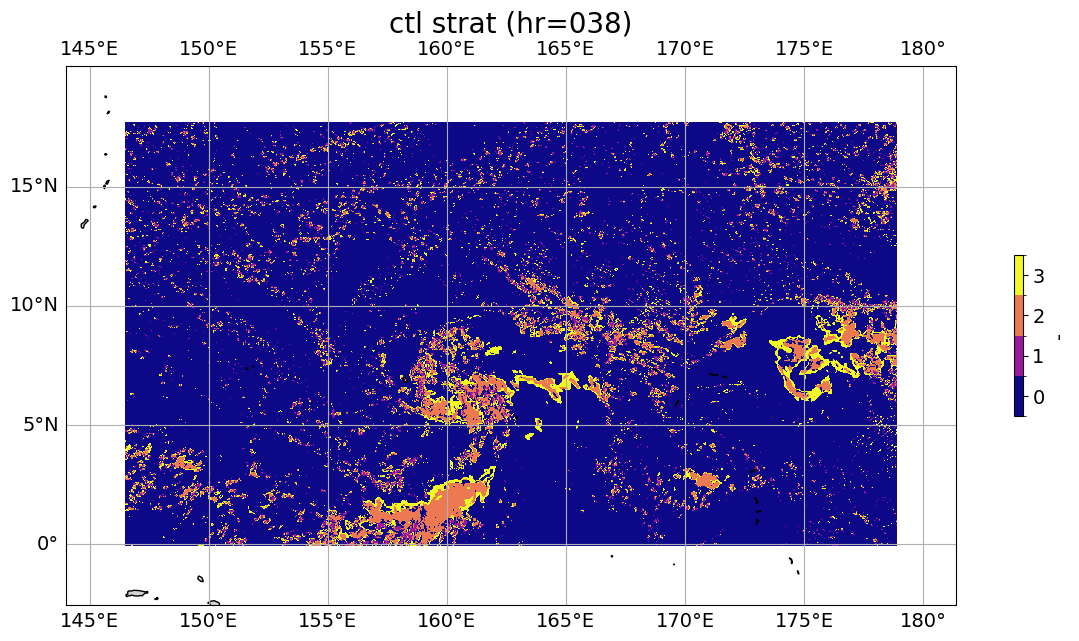

In [27]:
# ------ Stratiform plot

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

vartag='strat'
pltvar=strat
unittag='-'
clevs = np.arange(-30,30)

strat = mask_edges(strat)

# create figure
fig = plt.figure(figsize=(15,7))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
ax = fig.add_subplot(111,projection=proj)
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'
ax.set_title(title, fontsize=20)

# Poly fill approach
bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cols=[(255,255,255),(174,53,85),(136,178,89),(70,99,200)]
im = ax.pcolormesh(lon_offset_plt, lat, pltvar, norm=norm, cmap='plasma')
# cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar = plt.colorbar(im, ax=ax, shrink=0.3, ticks=(0,1,2,3))

cbar.ax.set_ylabel(unittag)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)

plt.show()
plt.close()

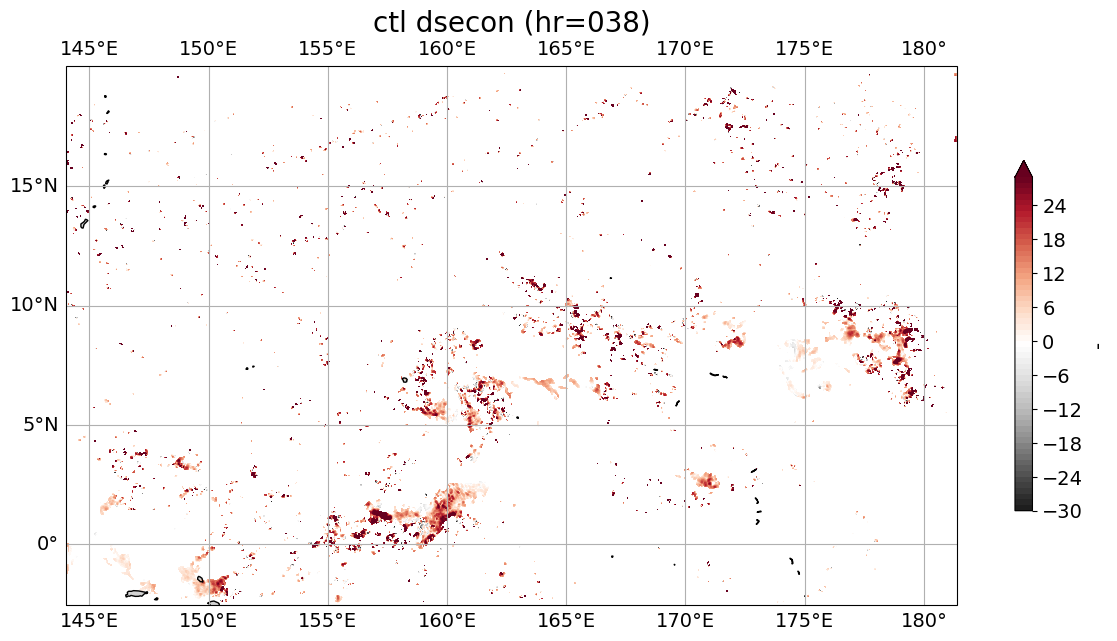

6.9269837659307845


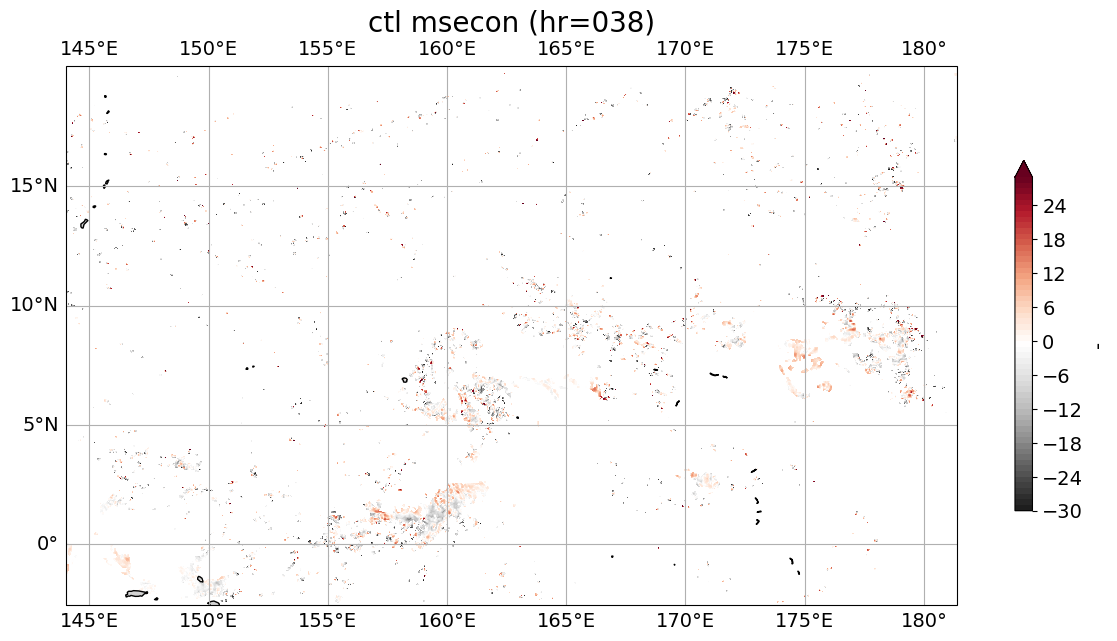

-6.750097901002507


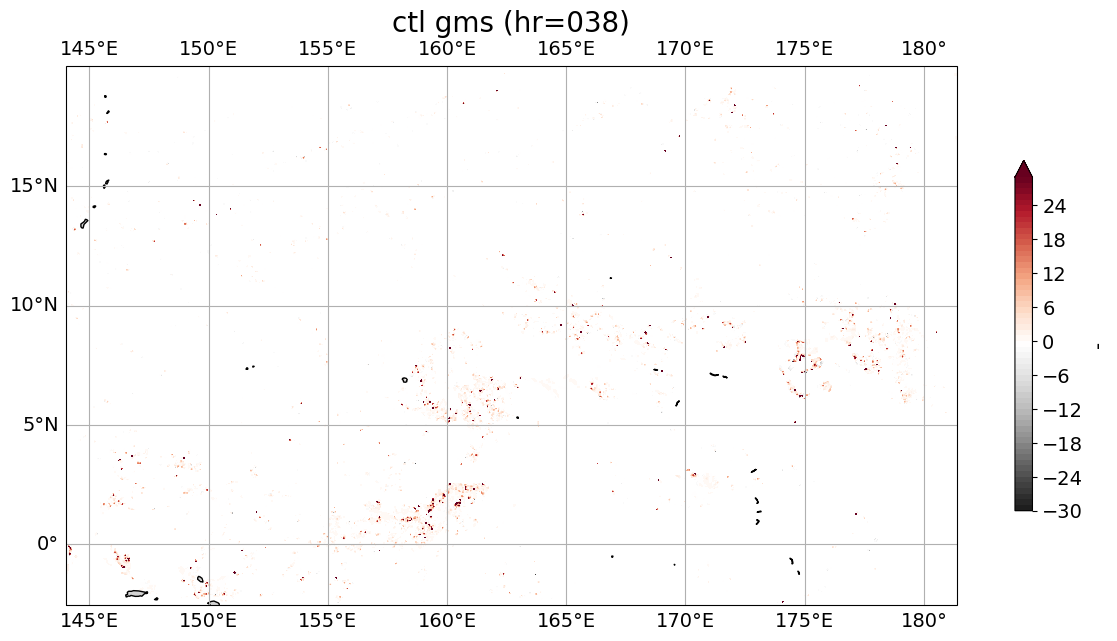

-0.31446879957540125


In [45]:
# ------ Plotting routines

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

# for kplot in range(0,3):
for kplot in range(0,3):

    if kplot == 0:
        vartag='dsecon'
        pltvar=dsecon * 1e-6
        unittag='-'
    elif kplot == 1:
        vartag='msecon'
        pltvar=msecon * 1e-6
        unittag='-'
    elif kplot == 2:
        vartag='gms'
        pltvar=gms
        unittag='-'

    clevs = np.arange(-30,30)
    title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

    # Conduct smoothing using running average
    # nwindow = 5 # width = n * 3 km
    # pltvar_pd1 = pd.DataFrame(pltvar)
    # pltvar_pd2 = pltvar_pd1.rolling(window=nwindow, center=True, closed='both', axis=0).mean()
    # pltvar_pd = pltvar_pd2.rolling(window=nwindow, center=True, closed='both', axis=1).mean()
    # pltvar = np.copy(pltvar_pd)

    istrat_mask = 2 # Mask out all but this
    pltvar = np.ma.masked_where((strat != istrat_mask),
                                pltvar, copy=True)

    # do_plot(pltvar_pd, unittag, title, clevs)
    do_plot(pltvar, unittag, title, clevs)
    print(np.mean(pltvar))